# 使用するライブラリのインポート

In [1]:
# 使用するライブラリのインポート
import pandas as pd
import numpy as np 
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# CSVファイルをデータフレーム形式として読み込み

In [2]:
# CSVファイルをデータフレーム形式として読み込み
# 保存先が異なる場合はパスも指定してあげましょう
 
ratings = pd.read_csv('archive/rating.csv')
anime = pd.read_csv('archive/anime.csv')

In [3]:
# ratingのデータフレームの最初の5行を表示
ratings.head() 

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
# animeのデータフレームをmemberの値で並び替え
anime.sort_values('members', ascending= False)[:10]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


# 基本統計量の確認

In [6]:
# animeの基本統計量の確認
round(anime.describe(),2)

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


In [7]:
# ratingsの基本統計量の確認
round(ratings.describe(),2)

,user_id,anime_id,rating
count,7813737.00,7813737.00,7813737.00
mean,36727.96,8909.07,6.14
std,20997.95,8883.95,3.73
min,1.00,1.00,-1.00
25%,18974.00,1240.00,6.00
50%,36791.00,6213.00,7.00
75%,54757.00,14093.00,9.00
max,73516.00,34519.00,10.00


上記の基本統計量のテーブルをみて、一つ特異なデータがあるのがわかります。 rating のカラムのmin（最小値）が-1とあります。レーティングですが、これはユーザーが各アニメにつけた評価ですよね？最小値の値が「-1」というのはデータとして特異なのが解るかと思います。

データセットの説明文を読んでみると、この「-1」ですが、「アニメを観たことがあるが、レーティング（評価）を付与しなかった」という意味とのことです。このように、データには様々な癖のようなものがあり、それらを最初の段階で把握するのは機械学習において非常に重要な作業です。

<AxesSubplot:>

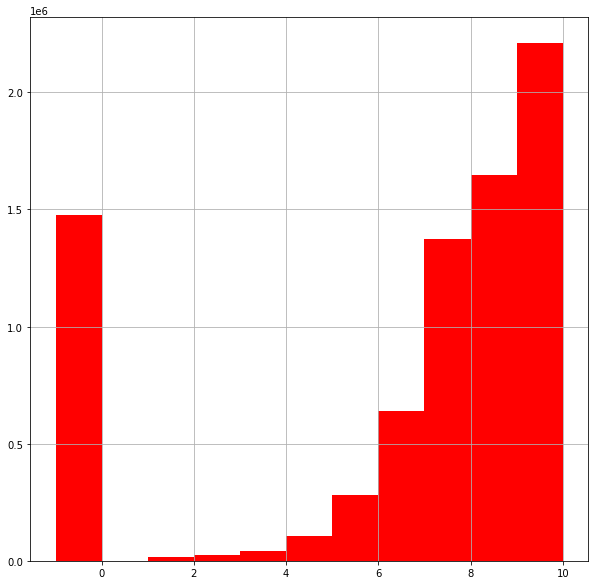

In [8]:
# ratingsのヒストグラムを作成
ratings['rating'].hist(bins=11, figsize=(10,10), color = 'red')

# データの前処理

これから構築するレコメンドエンジンの質を向上する為、 members （当該のアニメのグループに所属しているユーザー数）が10,000以下のデータを足切りをしましょう。足切りすることにより、これから構築するレコメンド機能が、メンバー数が少ないアニメ（つまり比較的人気の低いアニメ）をオススメしないようになります。

In [10]:
# membersの値が10,000より大きいデータのみに変更
anime = anime[anime['members'] > 10000]

In [11]:
# 欠損データの確認
anime.isnull().sum()

anime_id     0
name         0
genre        2
type         4
episodes     0
rating      43
members      0
dtype: int64

In [12]:
# 欠損データをdropna()でデータセットから取り除く
anime = anime.dropna()

In [20]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [13]:
# raitingの値が0以上のみ残す
ratings = ratings[ratings.rating >= 0]

In [19]:
ratings.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [15]:
ratings.describe()

,user_id,anime_id,rating
count,6.337241e+06,6.337241e+06,6.337241e+06
mean,3.674791e+04,8.902866e+03,7.808497e+00
std,2.101340e+04,8.882000e+03,1.572496e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.898400e+04,1.239000e+03,7.000000e+00
50%,3.681500e+04,6.213000e+03,8.000000e+00
75%,5.487300e+04,1.407500e+04,9.000000e+00
max,7.351600e+04,3.447500e+04,1.000000e+01


次にanimeとratingsのデータを「 anime_id 」を軸にして、「user_id」毎に切り分けてマージさせましょう。

これで、2つの異なるデータフレームが、ユーザーIDごとに切り分けられた一つのデータフレームとしてマージ（合体）しました。

In [16]:
# animeとratingsの2つのデータフレームをマージさせる
mergeddf = ratings.merge(anime, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
# 合体したデータフレームの最初の5行を表示
mergeddf.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,5,8074,2,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


In [17]:
# mergeddfの基本統計量の確認
round(mergeddf.describe(),2)

,user_id,anime_id,rating_user,rating,members
count,5957004.00,5957004.00,5957004.00,5957004.00,5957004.00
mean,36665.80,9023.38,7.87,7.74,196030.78
std,21030.91,8920.21,1.54,0.62,191317.96
min,1.00,1.00,1.00,2.37,10005.00
25%,18911.00,1195.00,7.00,7.35,57029.00
50%,36534.00,6500.00,8.00,7.74,130689.00
75%,54851.00,14345.00,9.00,8.17,271484.00
max,73516.00,34240.00,10.00,9.37,1013917.00


In [21]:
# 不必要な項目と重複項目を削除
mergeddf = mergeddf[['user_id','name','rating_user']]
mergeddf = mergeddf.drop_duplicates(['user_id','name'])
 
# head()で最初の5行を表示
mergeddf.head()

,user_id,name,rating_user
0,1,Highschool of the Dead,10
1,3,Highschool of the Dead,6
2,5,Highschool of the Dead,2
3,12,Highschool of the Dead,6
4,14,Highschool of the Dead,6


In [22]:
# データフレームのピボット
anime_pivot = mergeddf.pivot(index= 'name',columns='user_id',values='rating_user').fillna(0)
anime_pivot_sparse = csr_matrix(anime_pivot.values)

In [24]:
# anime_pivotの最初の10行を表示
anime_pivot.head(10)

user_id,1,2,3,5,7,8,9,10,11,12,...,73507,73508,73509,73510,73511,73512,73513,73514,73515,73516
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Intermezzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Liminality,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Quantum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# k近傍法（k-nearest neighbors）でレコメンド機能を構築

さて、いよいよ本題のレコメンド機能の構築です！今回構築するレコメンド機能ですが、k近傍法（ケイ・きんぼうほう）というアルゴリズムを利用してモデルを構築します。k近傍法ですが英語の「k-nearest neighbor（ケイ・ニアレスト・ネイバー）」またはその頭文字を取って「KNN」と呼ばれることも多いので、覚えておくと便利かと思います。

では、このk近傍法とは一体どのようなアルゴリズムなんでしょうか？

k近傍法ですが最も単純なアルゴリズムと呼ばれており、クラスタリングのアルゴリズムの一種で、一般的に分類問題などで利用されます。今回のチュートリアルの例で考えると、とあるアニメのタイトルを入力した際に、そのアニメのneighbors（ご近所さん）を探して、距離が近い（類似性が高い）アニメのタイトルをオススメとして返してくれます。

In [25]:
# Scikit-learnのライブラリを利用します
# n_neiborsやalgorithm、metricなど重要なアーギュメントを設定しています
knn = NearestNeighbors(n_neighbors=9,algorithm= 'brute', metric= 'cosine')
 
# 前処理したデータセットでモデルを訓練
model_knn = knn.fit(anime_pivot_sparse)

In [28]:
# データセットのタイトルをキーワードで検索
def searchanime(string):
    print(anime_pivot[anime_pivot.index.str.contains(string)].index[0:])
    
searchanime('Hajime')

Index(['Bokura wa Minna Kawaisou: Hajimete no', 'Hajime no Ippo',
       'Hajime no Ippo: Boxer no Kobushi', 'Hajime no Ippo: Champion Road',
       'Hajime no Ippo: Mashiba vs. Kimura', 'Hajime no Ippo: New Challenger',
       'Hajime no Ippo: Rising', 'Kamisama Hajimemashita',
       'Kamisama Hajimemashita OVA', 'Kamisama Hajimemashita: Kako-hen',
       'Kamisama Hajimemashita◎', 'Kyou, Koi wo Hajimemasu',
       'Natsume Yuujinchou: Nyanko-sensei to Hajimete no Otsukai',
       'Re:Petit kara Hajimeru Isekai Seikatsu',
       'Re:Zero kara Hajimeru Break Time',
       'Re:Zero kara Hajimeru Isekai Seikatsu',
       'Sekirei: Hajimete no Otsukai'],
      dtype='object', name='name')


In [29]:
# 「はじめの一歩」に対してのオススメのアニメ10個
Anime = 'Hajime no Ippo'
 
distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Hajime no Ippo:

1: Hajime no Ippo: New Challenger with distance: 0.16171263372777
2: Hajime no Ippo: Champion Road with distance: 0.30597377816318394
3: Hajime no Ippo: Mashiba vs. Kimura with distance: 0.34948858340614675
4: Hajime no Ippo: Rising with distance: 0.3635742899878238
5: Hajime no Ippo: Boxer no Kobushi with distance: 0.5808237633855784
6: Great Teacher Onizuka with distance: 0.6271421261955552
7: Shijou Saikyou no Deshi Kenichi with distance: 0.6428821544076411
8: Major S1 with distance: 0.6575993793656698
9: Major S2 with distance: 0.6623633646779645
10: One Outs with distance: 0.6644591854339764


In [30]:
# 「君の名は」を見たことがあるあなたにオススメのアニメは・・・
Anime = 'Kimi no Na wa.'
 
distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime Kimi no Na wa.:

1: Boku dake ga Inai Machi with distance: 0.6855242894481091
2: Re:Zero kara Hajimeru Isekai Seikatsu with distance: 0.6968551384446042
3: Shigatsu wa Kimi no Uso with distance: 0.703281384251974
4: ReLIFE with distance: 0.7191316277184874
5: One Punch Man with distance: 0.7426460533821271
6: Charlotte with distance: 0.7434996132820642
7: Noragami Aragoto with distance: 0.7486936229508915
8: Shokugeki no Souma with distance: 0.7585646506908518
9: Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku with distance: 0.7602916580493286
10: Noragami with distance: 0.7612671872707739


In [33]:
searchanime('World Tri')

Index(['World Trigger'], dtype='object', name='name')


In [34]:
# 「君の名は」を見たことがあるあなたにオススメのアニメは・・・
Anime = 'World Trigger'
 
distance, indice = model_knn.kneighbors(anime_pivot.iloc[anime_pivot.index== Anime].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendations if you like the anime {0}:\n'.format(anime_pivot[anime_pivot.index== Anime].index[0]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,anime_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendations if you like the anime World Trigger:

1: Ushio to Tora (TV) with distance: 0.725129836846506
2: God Eater with distance: 0.7264347744258586
3: Rokka no Yuusha with distance: 0.7390931717660554
4: Owari no Seraph: Nagoya Kessen-hen with distance: 0.7392465847776059
5: Divine Gate with distance: 0.7402057404028435
6: Ushio to Tora (TV) 2nd Season with distance: 0.7417892788084659
7: Gate: Jieitai Kanochi nite, Kaku Tatakaeri 2nd Season with distance: 0.742957247427183
8: Gakusen Toshi Asterisk 2nd Season with distance: 0.7430910174612433
9: Arslan Senki (TV) with distance: 0.7432550495089689
10: Log Horizon 2nd Season with distance: 0.7444127073903539
